<a href="https://colab.research.google.com/github/yusufakcakaya/Algorythm-NLP-Entity-Recognition/blob/Nichelle/Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here , we have implemented a knowledge graph from a random news text.
The article by [1] becominghuman.ai and [2] analyticsvidya and has been heavily referred for this. But we have made improvements in the form of :
1. Separating a text into sentences using spacy's sentencizer.
2. Saving it into a dataframe.
1. Data Preprocessing - Removed punctuations , stop words
2. Named Entity Recognition - This has helped in constructing a more meaningful graph with less noise.


In [2]:
import re
import pandas as pd
import spacy
from tqdm import tqdm
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string 
tqdm._instances.clear()

In [ ]:
#  text = 'The implementation of the French "pass sanitaire" (health pass) in the summer of 2021 is estimated to have saved nearly 4,000 lives in France, shows a recent study by the Conseil d’analyse économique (CAE). Health passes and vaccination certificates remain the subject of discussion (in Belgium too), but independent scientists from various universities and institutes found that France’s sudden implementation of the pass not only saved thousands of lives but also saved €6 billion for the country’s economy.After France had already imposed strict measures (such as a 18:00 curfew), it was among the first European countries to require its ‘pass sanitaire’ to gain access to bars and restaurants. From August, it became mandatory for large shopping centres, cultural venues and long bus and train journeys. Immediately after French President Emmanuel Macron announced on 12 July 2021 that the ‘pass sanitaire’ would be made mandatory to enter bars, restaurants and museums, vaccination appointments surged as almost a million first shots were booked the next day. Now, as the country tightened its rules again by replacing its “health pass” with a “vaccination pass,” the Conseil d’analyse économique published a study, which has not yet been peer-reviewed, to show the impact of the ‘pass sanitaire,’ focused on vaccination coverage, hospitalisations and deaths due to Covid-19, as well as its economic consequences.'

In [ ]:
# from spacy.lang.en import English

# nlp = English()  # just the language with no model
# sentencizer = nlp.create_pipe("sentencizer")
# nlp.add_pipe(sentencizer)
# sent = [sent.text for sent in nlp(text).sents]
# sent

['The implementation of the French "pass sanitaire" (health pass) in the summer of 2021 is estimated to have saved nearly 4,000 lives in France, shows a recent study by the Conseil d’analyse économique (CAE).',
 'Health passes and vaccination certificates remain the subject of discussion (in Belgium too), but independent scientists from various universities and institutes found that France’s sudden implementation of the pass not only saved thousands of lives but also saved €6 billion for the country’s economy.',
 'After France had already imposed strict measures (such as a 18:00 curfew), it was among the first European countries to require its ‘pass sanitaire’ to gain access to bars and restaurants.',
 'From August, it became mandatory for large shopping centres, cultural venues and long bus and train journeys.',
 'Immediately after French President Emmanuel Macron announced on 12 July 2021 that the ‘pass sanitaire’ would be made mandatory to enter bars, restaurants and museums, vaccin

In [ ]:
# import pandas as pd

# df1= pd.DataFrame(columns=["sentence"])

# df1 = df1.append(
#         [{'sentence' : sent.text} for sent in nlp(text).sents],
#         ignore_index=True
#     )
# df1

,sentence
0,"The implementation of the French ""pass sanitai..."
1,Health passes and vaccination certificates rem...
2,After France had already imposed strict measur...
3,"From August, it became mandatory for large sho..."
4,Immediately after French President Emmanuel Ma...
5,"Now, as the country tightened its rules again ..."


In [ ]:
# df1.to_csv('Data_1.csv')

In [ ]:
# from google.colab import files
# files.download("Data_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Data_1.csv to Data_1.csv


In [4]:
import io
sentences = pd.read_csv(io.BytesIO(uploaded['Data_1.csv']))

In [5]:
sentences.head()

,Unnamed: 0,sentence
0,0,"The implementation of the French ""pass sanitai..."
1,1,Health passes and vaccination certificates rem...
2,2,After France had already imposed strict measur...
3,3,"From August, it became mandatory for large sho..."
4,4,Immediately after French President Emmanuel Ma...


**Entity Pairs Extraction Function**

In [6]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      # Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix

      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
          #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + tok.text

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
        prev_token_dep = ""
        prev_token_text = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]    

Now lets obtain entity pairs from a sentence

In [7]:
[ent1,ent2] = get_entity("Paul keating is an economic forecaster from Australia")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("Paul keating is from Australia")

Subj : Paul keating, obj : economic  Australia


['Paul keating', 'Australia']

In [8]:
entity_pairs = []
for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()
entity_pairs

100%|██████████| 6/6 [00:00<00:00, 49.93it/s]


[['implementation', 'recent Conseil d’analyse économique'],
 ['various  France', 'country 6 economy'],
 ['18:00  it', 'European pass bars'],
 ['it', 'large shopping centres'],
 ['first  shots', '2021  bars'],
 ['again  which', 'due vaccination Covid-19']]

In [9]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]
subjects
objects

['recent Conseil d’analyse économique',
 'country 6 economy',
 'European pass bars',
 'large shopping centres',
 '2021  bars',
 'due vaccination Covid-19']

**Relation** **Extraction** 

The Relation between nodes has been extracted. The hypothesis is that the main verb or the Root word forms the relation between the subject and the object.

In [10]:


def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'VB','OP':'?'},{'POS':'ADJ','OP':'?'}]
   #define the pattern 
  # pattern = [{'DEP':'ROOT'}, 
  #           {'DEP':'prep','OP':"?"},
  #           {'DEP':'agent','OP':"?"},  
  #           {'POS':'ADJ','OP':"?"},
  #            {'ENT_TYPE':'PERSON', 'OP':'?'},
  #            {'ENT_TYPE':'GPE', 'OP':'?'}] 
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  #matches = matcher(doc)

  matches = matcher(doc)
  k = len(matches)-1


  span = doc[matches[k][1]:matches[k][2]] 
  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  #span = doc[matches[0][1]:matches[0][2]]
  return span.text


Below we observe a problem. The Relation for the second should be "couldn't complete", in order to correctly capture the semantics. But it fails to do so.

In [11]:
get_entity("John completed the task"), get_relation("John completed the task")

(['John', 'task'], 'completed')

In [12]:
get_entity("John couldn't complete the task"), get_relation("John couldn't complete the task")

(['John', 'task'], 'complete')

Anyway, we move on. Let's get the relations for the entire dataset

In [13]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
relations

100%|██████████| 6/6 [00:00<00:00, 71.89it/s]


['shows', 'remain', 'was among', 'became mandatory', 'surged', 'published']

In [14]:
# extract subject
source = [i[0] for i in entity_pairs] 
# extract object
target = [i[1] for i in entity_pairs] 


kg_df = pd.DataFrame({'source':source,'target':target,'edge':relations})
kg_df

,source,target,edge
0,implementation,recent Conseil d’analyse économique,shows
1,various France,country 6 economy,remain
2,18:00 it,European pass bars,was among
3,it,large shopping centres,became mandatory
4,first shots,2021 bars,surged
5,again which,due vaccination Covid-19,published


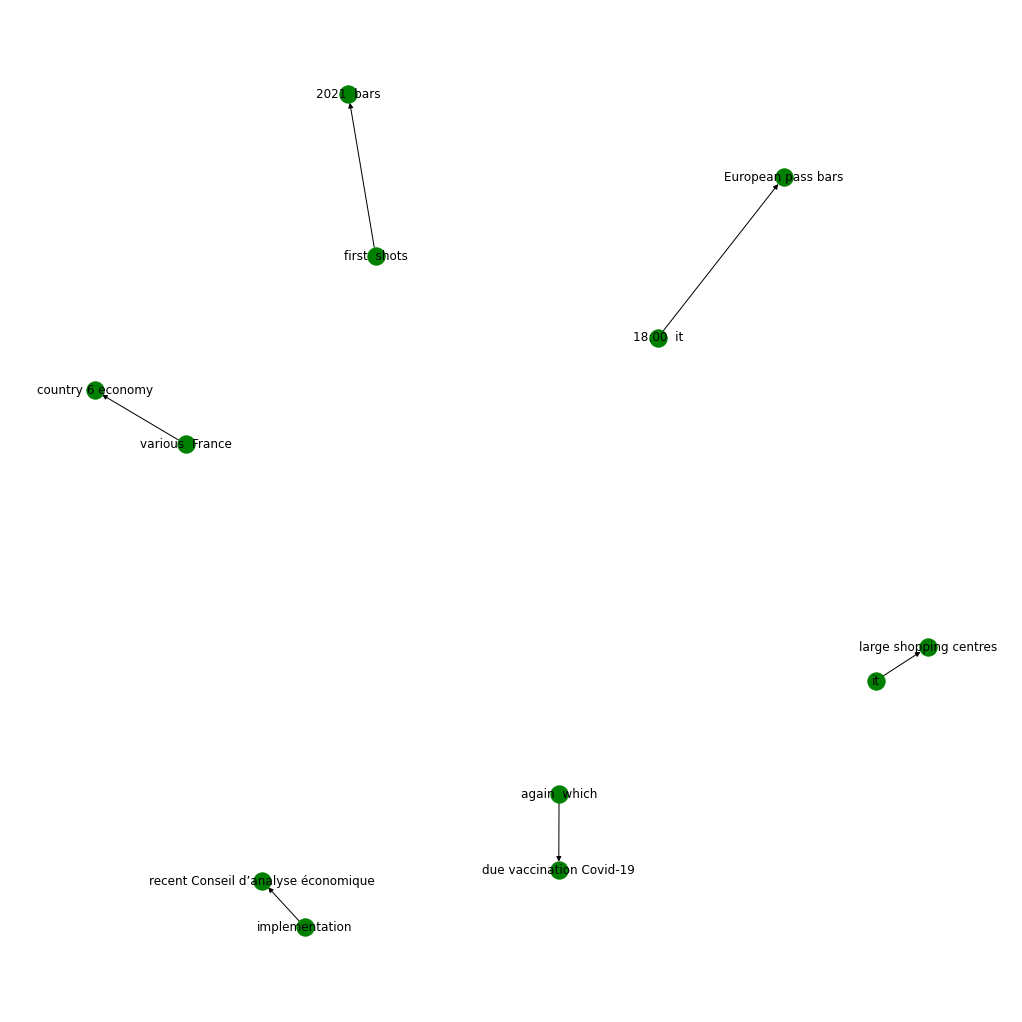

In [15]:
 
import matplotlib.pyplot as plot
# Create DG from the dataframe
graph = nx.from_pandas_edgelist(kg_df, "source", "target",
                         edge_attr=True, create_using=nx.MultiDiGraph())
# plotting the network
plot.figure(figsize=(14, 14))
posn = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

Let's look at the topmost occuring subjects 

In [16]:
pd.Series(subjects).value_counts()

it                 1
implementation     1
again  which       1
18:00  it          1
first  shots       1
various  France    1
dtype: int64

We observe that these words are mostly generic, hence of not much use to us.


In [17]:
pd.Series(relations).value_counts()[:10]

shows               1
was among           1
remain              1
surged              1
published           1
became mandatory    1
dtype: int64

Not surprisingly, "is" and "was" forms the most common relations, simply because they are the most common words. We want more meaningful subjects to be more prominent.

**Data Pre - Processing**

Let's see what happens if we pre-process the data.
We remove stopwords and punctuation marks

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
import re
stop_words = stopwords.words('english')

# Code to remove special characters
def prep(string):
    string = string.replace("'", "") #apostrophe
    string = string.replace('"',"") #double quotes
    #string = string.replace(",","") #comma
    string = string.replace(" . ", ".") #removing space between '.'
    string = string.replace(" / ", "/") #removing space between '/'
    string = re.sub('\s+[a-zA-Z]\s+', ' ',string) #removing single alphabetical characters
    string = re.sub("pct|PCT", "%", string) #replacing 'pct' with the symbol '%'
    string = string.replace("dlrs","dlr")
    string = string.replace("mln", "million")
    string = string.replace("U.S.", "United States of America ")
    string = ' '.join(word for word in string.split(' ') if word not in stop_words)
    return string

In [35]:
preprocessed_sentences = [prep(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()
preprocessed_sentences


100%|██████████| 6/6 [00:00<00:00, 2577.94it/s]


['The implementation French pass sanitaire (health pass) summer 2021 estimated saved nearly 4,000 lives France, shows recent study Conseil d’analyse économique (CAE).',
 'Health passes vaccination certificates remain subject discussion (in Belgium too), independent scientists various universities institutes found France’s sudden implementation pass saved thousands lives also saved €6 billion country’s economy.',
 'After France already imposed strict measures (such 18:00 curfew), among first European countries require ‘pass sanitaire’ gain access bars restaurants.',
 'From August, became mandatory large shopping centres, cultural venues long bus train journeys.',
 'Immediately French President Emmanuel Macron announced 12 July 2021 ‘pass sanitaire’ would made mandatory enter bars, restaurants museums, vaccination appointments surged almost million first shots booked next day.',
 'Now, country tightened rules replacing “health pass” “vaccination pass,” Conseil d’analyse économique publis

Getting entity pairs from preprocessed sentences

In [36]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████| 6/6 [00:00<00:00, 69.83it/s]


In [37]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|██████████| 6/6 [00:00<00:00, 67.34it/s]


In [38]:
pd.Series(relations).value_counts()[:10]

saved               1
announced           1
became mandatory    1
tightened           1
require             1
shows recent        1
dtype: int64

We see above that only the important relations are present, "released" being the most common. There is no "is", "was" and trivial words as before.This fulfils our desire if eliminating noise.

What if we only want Named Entities to be present? Entities like Actors, Films,
Studios, Composers etc

In [39]:
entity_pairs2 = entity_pairs
relations2 = relations

In [40]:
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████| 6/6 [00:00<00:00, 45100.04it/s]


As we observe, the number of relations decrease to 2851 . Previously it was around 4k

**Named Entity Recognition Using Spacy**

In [41]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])


We had obtained entity pairs before but they had many irrelevant words.
We narrowed them down quite a bit by preprocessing. Now, we obtain the named entity pairs which will form source and target respectively.
It looks like (source, target, edge). We prune this further by removing all the data which have neither source or target entity as a Named Entity.
We keep the rest. The Relations that were extracted before form the edge

**Now, we find the most popular Source , Target and Relations**

In [42]:
print("###################   Source entites    ###################### \n",pd.Series(source).value_counts()[:10])
print("###################  Target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Relationship between entities        ###################### \n",pd.Series(relations).value_counts()[:20])

###################   Source entites    ###################### 
 enter vaccination appointments    1
European  countries               1
thousands  lives                  1
                                  1
dtype: int64
###################  Target entites    ###################### 
 August                               1
first  shots                         1
6 billion 6 country                  1
sanitaire access bars restaurants    1
dtype: int64
###################  Relationship between entities        ###################### 
 saved               1
announced           1
became mandatory    1
tightened           1
require             1
shows recent        1
dtype: int64


**Constructing the Knowledge Graph**

We first take the knowledge graph in a pandas dataframe. It will be a directional graph.

In [43]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df
#MultiDIGRaph because its a directional graph

,source,target,edge
0,thousands lives,6 billion 6 country,saved
1,European countries,sanitaire access bars restaurants,require
2,,August,became mandatory
3,enter vaccination appointments,first shots,announced


In [44]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [45]:
G = nx.from_pandas_edgelist(knowledge_graph_df, source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph

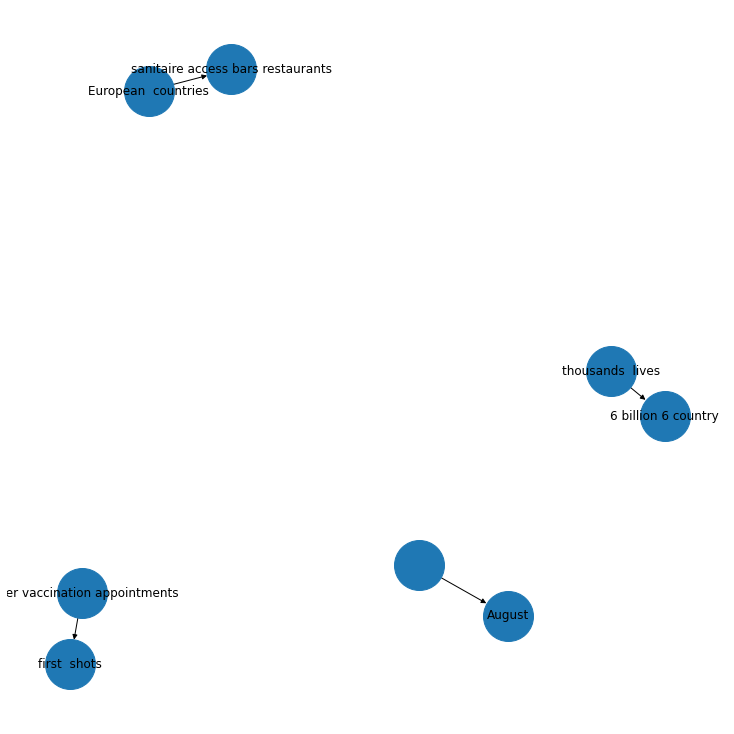

In [46]:
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

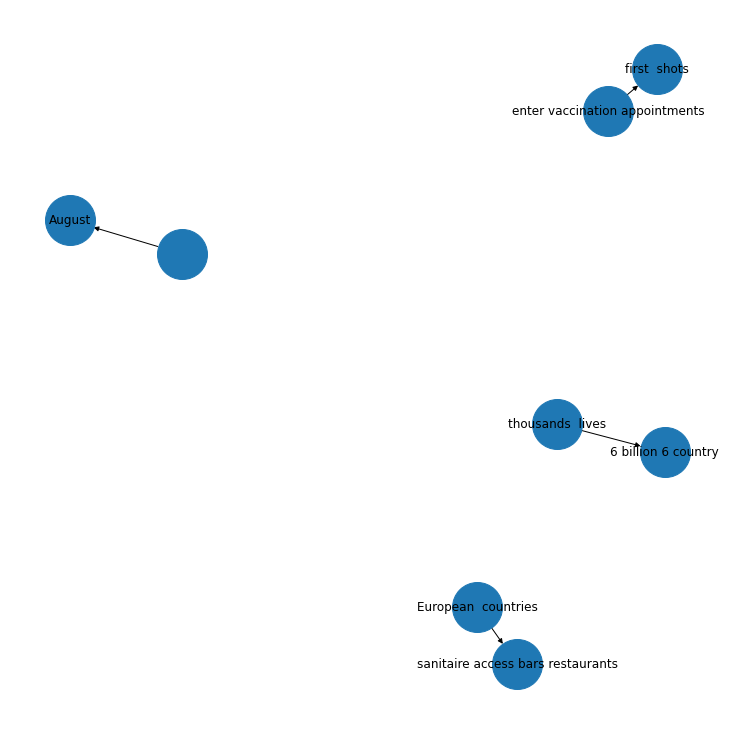

In [47]:
G = nx.from_pandas_edgelist(knowledge_graph_df,source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

**References**
1. https://becominghuman.ai/building-a-small-knowledge-graph-using-ner-296930592bcf
2. https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/